1. 오토인코더 ipynb 파일에서 모델 구동해서 Loss 값을 Type_A_anomaly_pickle 폴더에 하나하나 저장
2. 해당 파일의 Loss 값을 가져온 뒤 해당 파일의 데이터를 불러옴 

In [1]:
import re
import pandas as pd

import matplotlib.pyplot as plt

import datetime
import time

import copy

In [2]:
df = pd.read_csv('../../Processing/data/Type_A/아시아앤.csv')
df = df[df['채널명'] == '아시아앤']

In [3]:
df.head()

,삽입날짜,삽입시간,광고타입,큐톤ID,서비스ID,채널명,OTV 채널번호,OTS 채널번호,서버 타입,Time,...,일,토,화,Year,Month,Day,Hour,Min,Sec,Loss
0,2021-10-01,2022-07-20 10:55:22,A,119,317,아시아앤,111,54,M,105522,...,0,0,0,2021,10,10,10,55,22,0.291579
1,2021-10-01,2022-07-20 10:57:30,A,119,317,아시아앤,111,54,M,105730,...,0,0,0,2021,10,10,10,57,30,0.254114
2,2021-10-01,2022-07-20 10:59:15,B,917,317,아시아앤,111,54,M,105915,...,0,0,0,2021,10,10,10,59,15,0.444711
3,2021-10-01,2022-07-20 11:00:23,B,917,317,아시아앤,111,54,M,110023,...,0,0,0,2021,10,10,11,0,23,0.565273
4,2021-10-01,2022-07-20 11:55:08,A,119,317,아시아앤,111,54,M,115508,...,0,0,0,2021,10,10,11,55,8,0.336137


## 이상데이터 저장

In [4]:
## 오토인코더 결과 Loss 값 불러오기

import pickle
# load
with open('../../Processing/data/Type_A_anomaly_pickle/아시아앤.pickle', 'rb') as f:
    data = pickle.load(f)

In [5]:

window_size = 10
lower_threshold = 0.3
upper_threshold = 0.307

pd.set_option('display.max_rows', 200)

test_df = copy.deepcopy(data.loc[window_size:]).reset_index(drop=True)

print(len(test_df.loc[(test_df.Loss>lower_threshold) & (test_df.Loss<upper_threshold)]))
test_df.loc[(test_df.Loss>lower_threshold) & (test_df.Loss<upper_threshold)]

## 이상값 csv 따로 저장
anomaly = test_df.loc[(test_df.Loss>lower_threshold) & (test_df.Loss<upper_threshold)] 
channel_name = anomaly['채널명'].unique().tolist()
for chat_name in channel_name :
    chat_csv = None
    chat_csv = anomaly[anomaly['채널명'] == chat_name]
    chat_csv.to_csv('../../Processing/data/Type_A_anomaly_csv/'+str(chat_name)+'.csv', index=False)

df = test_df.copy()
df['삽입날짜'] = df['삽입날짜'].astype(str)
df['삽입시간'] = df['삽입시간'].astype(str)

lists = [] 
for i in range(len(df)) :
    times = df['삽입시간'][i][11:]
    lists.append(times)
df['삽입시간'] = None
df['삽입시간'] = lists


243


## 그래프 생성

In [6]:
def clean_text(inputString):
    text_rmv = re.sub('[=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
    
df['삽입날짜'] = df['삽입날짜'].apply(clean_text)
df['삽입날짜'] = df['삽입날짜'].str.strip()

In [47]:
def drawing_paper(df):
    date_min = df['삽입날짜'].min()
    date_max = df['삽입날짜'].max()

    fig, ax = plt.subplots(figsize=(120, 30))

    date_list = []

    append_date = date_min
    append_date = datetime.datetime.strptime(append_date, '%Y-%m-%d')

    while True:
        if append_date == datetime.datetime.strptime(date_max, '%Y-%m-%d'):
            break

        date_list.append(datetime.datetime.strftime(append_date, '%Y-%m-%d'))
        append_date = append_date + datetime.timedelta(days=1)

    ax.set_xticks(range(len(date_list)))
    ax.set_xticklabels(date_list)

    ax.set_xlim([-1, len(date_list)])
    ax.tick_params(axis='x', rotation=60)

    time_0 = datetime.datetime.strptime('00:00:00', '%H:%M:%S')
    time_24 = datetime.datetime.strptime('23:59:59', '%H:%M:%S')

    time_list = []

    append_time = time_0

    while True:
        time_list.append(append_time)
        if append_time > time_24:
            break
        append_time = append_time + datetime.timedelta(hours=1)

    time_list_str = [datetime.datetime.strftime(t, '%H:%M:%S') for t in time_list]
    time_list = [time.mktime(t.timetuple()) for t in time_list]

    ax.set_ylim([time_list[0], time_list[-1]])
    ax.set_yticks(time_list)
    ax.set_yticklabels(time_list_str)

    ax.grid(axis='y')
    return fig, ax, date_list

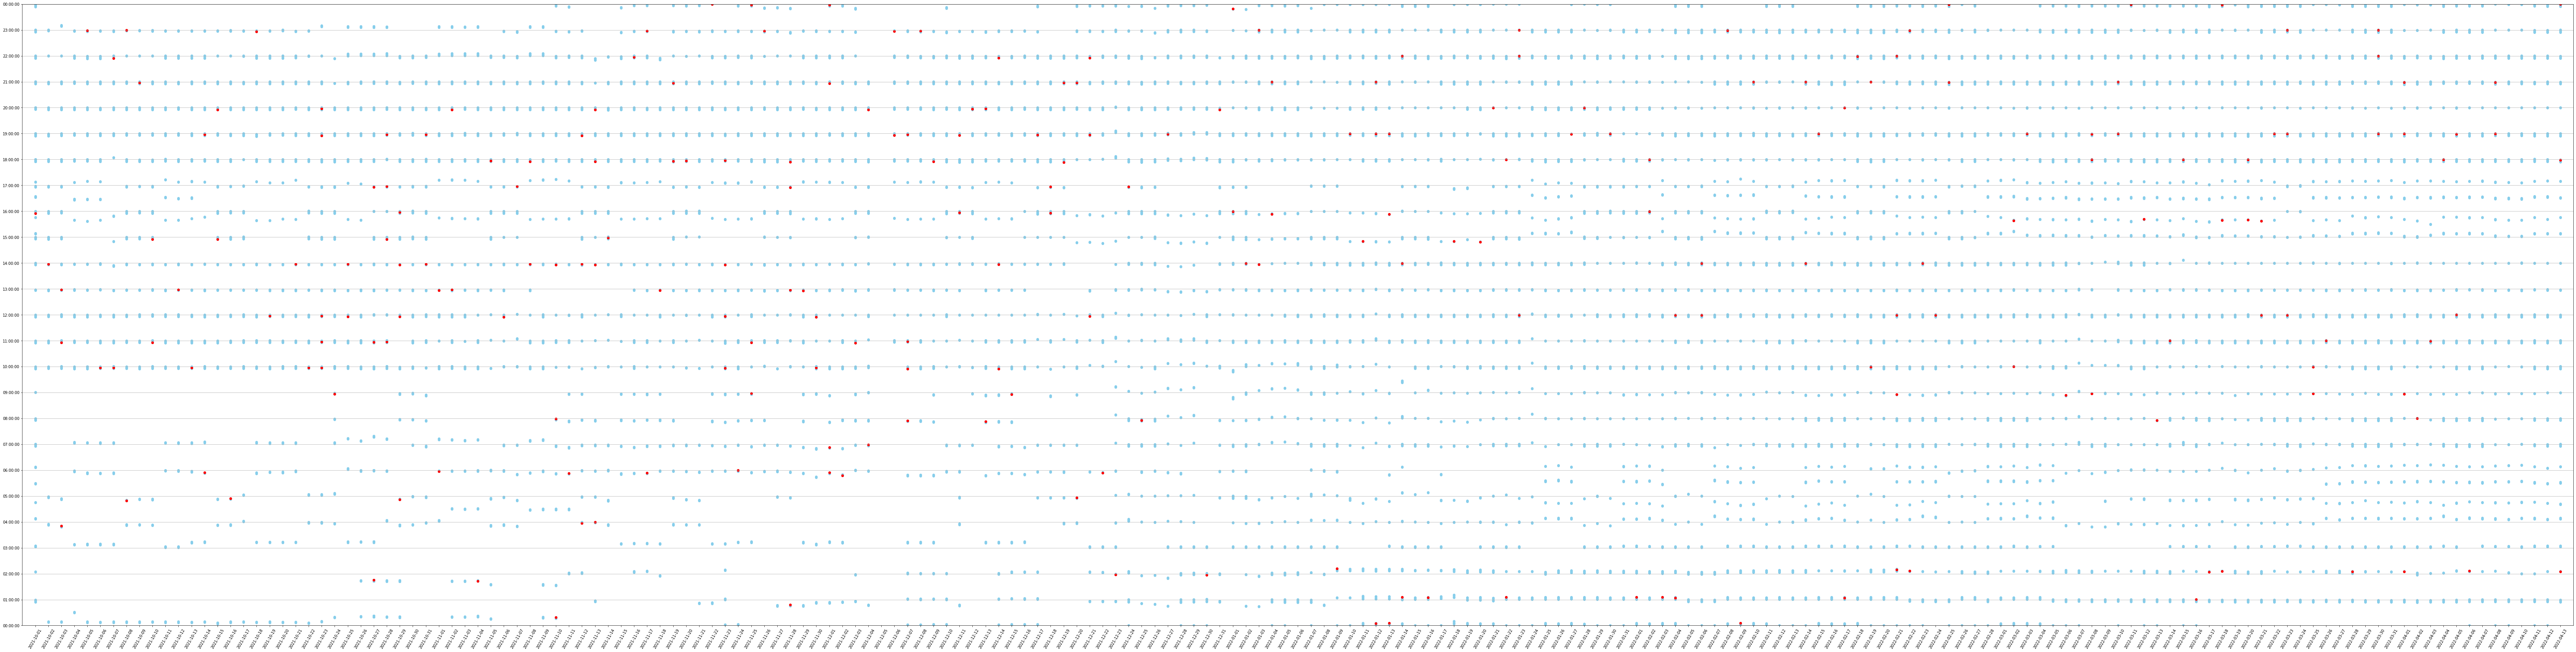

In [48]:
## 그래프 생성

fig, ax, date_list = drawing_paper(df.loc[df['채널명']==str(df['채널명'][0])])
date_dict = {d:idx for idx, d in enumerate(date_list)}
date_dict['2022-04-14'] = '195'

ax.scatter(date_dict['2021-10-05'], time.mktime(datetime.datetime.strptime('10:00:00', '%H:%M:%S').timetuple()))
df_target = df.copy()


## 전체 데이터 입력    
for i in range(len(df_target)) :
    ax.scatter(date_dict[df_target['삽입날짜'][i]], time.mktime(datetime.datetime.strptime(df_target['삽입시간'][i], '%H:%M:%S').timetuple()),  color = 'skyblue')


## 이상 데이터 입력
anomaly = pd.read_csv('../../Processing/data/Type_A_anomaly_csv/아시아앤.csv')
lists = [] 
for i in range(len(anomaly)) :
    times = anomaly['삽입시간'][i][11:]
    lists.append(times)
anomaly['삽입시간'] = None
anomaly['삽입시간'] = lists
for i in range(len(anomaly)) :
    ax.scatter(date_dict[anomaly['삽입날짜'][i]], time.mktime(datetime.datetime.strptime(anomaly['삽입시간'][i], '%H:%M:%S').timetuple()),  color = 'red')
